In [1]:
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os

sample_img_path = os.getenv('HOME')+'/aiffel/data_augmentation/images/mycat.jpg'
sample_img_path

'/home/aiffel-dj26/aiffel/data_augmentation/images/mycat.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


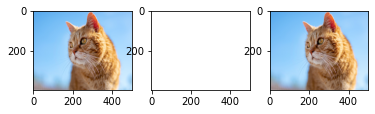

In [92]:
image = Image.open(sample_img_path).resize((500, 400)) # 이미지에 따라 숫자를 바꾸어 보세요.
image_tensor = tf.keras.preprocessing.image.img_to_array(image)
plt.subplot(1,3,1)
plt.imshow(image)
cropped_tensor = tf.image.random_brightness(image_tensor,100)
cropped_img = tf.keras.preprocessing.image.array_to_img(cropped_tensor)
test = tf.image.random_brightness(image_tensor,255)
test1 = tf.keras.preprocessing.image.array_to_img(test,scale=[0,255])
plt.subplot(1,3,2)
plt.imshow(test)
plt.subplot(1,3,3)
plt.imshow(test1)
#plt.imshow(image)
plt.show()

In [96]:
image = Image.open(sample_img_path).resize((500, 400)) # 이미지에 따라 숫자를 바꾸어 보세요.
image_tensor = tf.keras.preprocessing.image.img_to_array(image)
test = tf.image.random_brightness(image_tensor,255)
test_to_img = tf.keras.preprocessing.image.array_to_img(test)
img_to_test = tf.keras.preprocessing.image.img_to_array(test_to_img)
print(image_tensor)
print(test)
print(img_to_test)


[[[ 87. 166. 235.]
  [ 87. 166. 235.]
  [ 87. 166. 235.]
  ...
  [149. 199. 250.]
  [149. 199. 250.]
  [149. 199. 250.]]

 [[ 87. 166. 235.]
  [ 87. 166. 235.]
  [ 87. 166. 235.]
  ...
  [149. 199. 250.]
  [149. 199. 250.]
  [150. 200. 251.]]

 [[ 87. 166. 235.]
  [ 88. 167. 236.]
  [ 88. 167. 236.]
  ...
  [149. 199. 250.]
  [149. 199. 250.]
  [149. 199. 250.]]

 ...

 [[163. 149. 152.]
  [163. 149. 152.]
  [164. 149. 152.]
  ...
  [189. 225. 251.]
  [190. 226. 252.]
  [191. 227. 253.]]

 [[162. 150. 154.]
  [162. 150. 155.]
  [165. 150. 155.]
  ...
  [189. 225. 251.]
  [191. 226. 252.]
  [192. 226. 253.]]

 [[163. 151. 155.]
  [163. 151. 155.]
  [166. 151. 156.]
  ...
  [189. 225. 251.]
  [191. 226. 252.]
  [192. 226. 253.]]]
tf.Tensor(
[[[-126.98105   -47.98105    21.018951]
  [-126.98105   -47.98105    21.018951]
  [-126.98105   -47.98105    21.018951]
  ...
  [ -64.98105   -14.981049   36.01895 ]
  [ -64.98105   -14.981049   36.01895 ]
  [ -64.98105   -14.981049   36.01895 ]]

 [[

In [90]:
image_tensor
image
# print(tf.keras.preprocessing.image.img_to_array(test))
print(test)
# tf.keras.preprocessing.image.img_to_array(test1)
tf.keras.preprocessing.image.img_to_array(test1)

tf.Tensor(
[[[115.98886 194.98886 263.98886]
  [115.98886 194.98886 263.98886]
  [115.98886 194.98886 263.98886]
  ...
  [177.98886 227.98886 278.98886]
  [177.98886 227.98886 278.98886]
  [177.98886 227.98886 278.98886]]

 [[115.98886 194.98886 263.98886]
  [115.98886 194.98886 263.98886]
  [115.98886 194.98886 263.98886]
  ...
  [177.98886 227.98886 278.98886]
  [177.98886 227.98886 278.98886]
  [178.98886 228.98886 279.98886]]

 [[115.98886 194.98886 263.98886]
  [116.98886 195.98886 264.98886]
  [116.98886 195.98886 264.98886]
  ...
  [177.98886 227.98886 278.98886]
  [177.98886 227.98886 278.98886]
  [177.98886 227.98886 278.98886]]

 ...

 [[191.98886 177.98886 180.98886]
  [191.98886 177.98886 180.98886]
  [192.98886 177.98886 180.98886]
  ...
  [217.98886 253.98886 279.98886]
  [218.98886 254.98886 280.98886]
  [219.98886 255.98886 281.98886]]

 [[190.98886 178.98886 182.98886]
  [190.98886 178.98886 183.98886]
  [193.98886 178.98886 183.98886]
  ...
  [217.98886 253.98886 279.

array([[[ 87., 166., 235.],
        [ 87., 166., 235.],
        [ 87., 166., 235.],
        ...,
        [149., 199., 250.],
        [149., 199., 250.],
        [149., 199., 250.]],

       [[ 87., 166., 235.],
        [ 87., 166., 235.],
        [ 87., 166., 235.],
        ...,
        [149., 199., 250.],
        [149., 199., 250.],
        [150., 200., 251.]],

       [[ 87., 166., 235.],
        [ 88., 167., 236.],
        [ 88., 167., 236.],
        ...,
        [149., 199., 250.],
        [149., 199., 250.],
        [149., 199., 250.]],

       ...,

       [[163., 149., 152.],
        [163., 149., 152.],
        [164., 149., 152.],
        ...,
        [189., 225., 251.],
        [190., 226., 252.],
        [191., 227., 253.]],

       [[162., 150., 154.],
        [162., 150., 155.],
        [165., 150., 155.],
        ...,
        [189., 225., 251.],
        [191., 226., 252.],
        [192., 226., 253.]],

       [[163., 151., 155.],
        [163., 151., 155.],
        [166., 1